## Pre-face
This notebook independently shows our final project for 42186 Model-Based Machine Learning. Additional info and results can be found in our report which has been handed in as an appendix.

All obtained outputs are shown in the notebook but it can not run again without having all data ready. If you wish to work with this notebook go to following repository:

https://github.com/MikkelGroenning/MBML_project_generate_data?fbclid=IwAR2iQe5oScUf-9Eteya-6ivB1_Z3sSPmjKO5AzAOzmpJkYTLEe-T0xkUkT0

This includes two python scripts that can be used to get the data and preprocess it as we have done. Opening the notebook from this repository after having run these scripts should allow this notebook to be edited. See the readme for more info.

## Introduction

In this project we will use topic modelling to investigate topics dicussed in the Danish Parliment between 2009 and 2017. The overall goal is to find temporal evolutions in the topics discussed in the parliment by using dynamic topic models (DTM). As a simpler start we witll use latent dirichlet allocation (LDA) to extract some topics over the full time period. We use freely available transcripts from the Danish Parliment in the given time-period for our analysis.

## Data
In this part we will give an overview of the data, how to get it and how we preprocessed it to suit out needs.

### Raw Data

The raw data consists of 10 XML-files taking up roughly 300 MB, which can be found here: 

https://repository.clarin.dk/repository/xmlui/handle/20.500.12115/8

The data contains complete transcripts of parliamentary speeches from October 2009 through May 2017. To each speech there are information about when it was said, who said it with name, party and role in the parliment, what agenda point was dicussed and what was acutally said. More features were available which had no relevance to us. The raw data consists of approximately 380.000 observations (speeches) with roughly 40 million words in total.

### Getting the data

The data can be downloaded from the link above. We have though made it easier to get started by using the python script `makedata.py` (see the github mention in the pre-face) to automatically download the data and set it up correctly to our needs (only extracting relevant features). The resulting data frame can then be preprocessed as explaiend below.


### Preproccesing of the data

After having the data preproccesing was needed. We spend in total 15-20 hours on this and all the code can all be found in the script `buildfeatures.py` (see the github mention in the pre-face). A brief overview of what was done is shown below:

1. Remove all speeches from the speaker as this person acts a mediator in the parliment. This approximately halves the number of speeches.

2. Label party for all speeches. If members are in office for a given speech. their party is labeled as NA. We have filled all these manually.

3. Merging North Atlantic parties. In the parliment are small North Atlantic parties. They are merged into one so they have a bit more represented.

4. Merging speeches from same party within same agenda point. In order to reduce dimensions we did this merging under the assumption that a party have a same feeling about the topic discussed within an agenda point even though they have multiple speeches. This reduced the number of observations with about a factor 6 - but it made the speeches longer.

5. For all speeches we removed stopwords and stemmed the words. 

6. Convert all speeched to a bag-of-words representation and only keep words that are said a minimum of 50 times.

7. Remove 'common words' which we define as words used in at least 40% of the agenda point discussed in parliment. These words can be seen as domain specific stop words.

8. Perform term frequency–inverse document frequency (tf-idf) to have a _weighting_ for words.

With these measures in place the data is ready which can be loaded after running the `buildfeatures.py` script:

In [1]:
# Package import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
sys.path.append('..')


# Data import
from src.features.build_features import processed_path
from src.features.build_features import df, vocabulary, X, X_tfidf, corpus, corpus_tfidf

With this import we have the following: 

- **df**: Dataframe with 33734 observations including the date of a speech, agenda point, party and the raw text of what was said.

- **vocabulary**: Dictionary which maps word indicies to their corresponding word.

- **X**: Bag of words representation of each speech. The vocabulary length is 23203.

- **X_tfidf**: X with tfidf performed.

- **corpus**: A list of lists where each list correspond to an speech. Each of these lists contains tuples where each tuple corresponds to a word and how many times it was said.

- **corpus**: Same as above but instead of summing the X matrix it is done by summing X_tfidf.

### Synthetic data

The actual data set is very large and when running the Pyro-models on the full dataset we run into time and memory issues of the optimization. We have therefore created a much smaller synthetic dataset which can be used in the Pyro-models we have created. There are Python-libraries that has implemented LDA and DTM much more efficient that is possible to use on the real data that we can use to extract some real results. The synthetic data can then be used to demontrate the functionality of the Pyro-models.


The following blocks of code will generate synthetic documents belonging to a given topic across 100 time stamps. A total of five topics will be used to create the data. Firstly the probability of each topic for each timestamp is generated. The probabilities have to sum to 1 so it corresponds to all topics discussed. For the first time stamp a non-uniform dirichlet is used as this ensures that the probabilities sum top 1. When propegating forward in time autocorrelation is desired as this would be expected in the real parliment. Therefore a new probability for a given topic is drawn from a normal distribution with mean equaling the previous probability. Due to the stochastic element of the normal distribution some new probabilities can end up negative which is problematic. Therefore, if any probabilities are negative a random constant (based on a uniform distribution) is added to make all numbers positive. Lastly the data is normalized for each time stamp so the numbers corresponds to probabilities. Below the cell a plot of the probabilities over time can be seen.

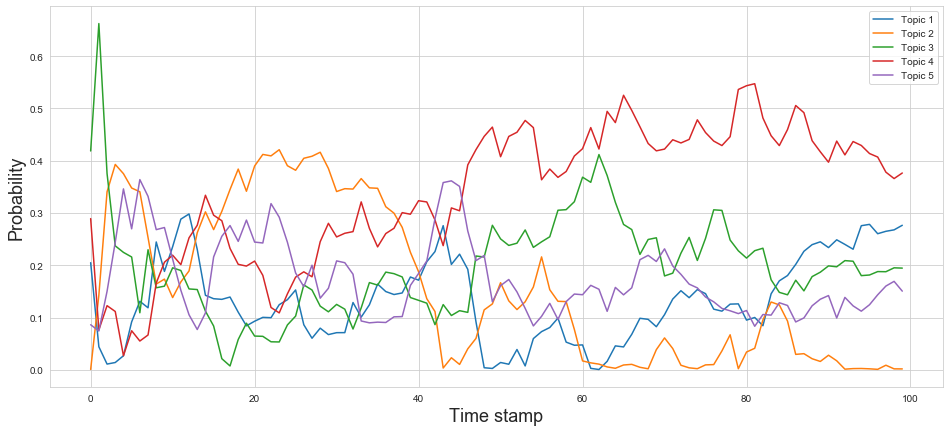

In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt

# Set seed
np.random.seed(123)

# Set number of topics, words per topic and time points
topics = 5
word_topic = 25
T = 100

# Initialize time series and first time step using dirichlet
time_series = np.zeros((T,topics))
time_series[0,:] = np.random.dirichlet(np.array([0.2,0.2,0.3,0.5,0.4]))

# Fill remaining time points
for i in range(1,T):
    
    # Use previous time stamp to create new one
    tmp = np.random.normal(loc = time_series[i-1,:], scale=1)
    
    # Make sure no negative values
    if tmp.min() < 0:
        tmp+= np.random.uniform(-1.2*tmp.min(),-1.5*tmp.min())
        
    # Append new time stamp
    time_series[i,:] = tmp

# Normalizae time series
time_series = time_series / time_series.sum(axis=1).reshape(-1,1)

# Visualize the time series
plt.figure(figsize = (16,7))
plt.plot(time_series)
plt.xlabel("Time stamp", fontsize = 18)
plt.ylabel("Probability", fontsize = 18)
plt.legend(('Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'))
plt.show()

Now we need to have a list of words and corresponds probabilties for it beloing to each topic. 25 words *fits* each topic for a total of 125 words. For each word the probability for it corresponds to its main topic is drawn from a uniform distribution with a lower bound of 0.7 and upper bound of 0.3. The remaining probabilities for the other topics are drawn from a sparse dirichlet, which is normalised so the sum of probabilities for each word sum up to 1.

In [3]:
# Initialize matrix
word_prob = np.zeros((word_topic*topics,5))

# Fill out probabilities of main words
for i in range(topics):
    word_prob[i*word_topic:(i+1)*word_topic,i] = np.random.uniform(0.7,0.9,word_topic)
    
    
# Fill the remaining 
for i in range(word_topic*topics):
    if i < word_topic:
        diff = (1-word_prob[0:word_topic, 0]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[0:word_topic, 1] = fill[:, 0]
        word_prob[0:word_topic, 2] = fill[:, 1]
        word_prob[0:word_topic, 3] = fill[:, 2]
        word_prob[0:word_topic, 4] = fill[:, 3]
    
    elif i < 2*word_topic:
        diff = (1-word_prob[word_topic:2*word_topic, 1]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[word_topic:2*word_topic, 0] = fill[:, 0]
        word_prob[word_topic:2*word_topic, 2] = fill[:, 1]
        word_prob[word_topic:2*word_topic, 3] = fill[:, 2]
        word_prob[word_topic:2*word_topic, 4] = fill[:, 3]
        
    elif i < 3*word_topic:
        diff = (1-word_prob[2*word_topic:3*word_topic, 2]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[2*word_topic:3*word_topic, 0] = fill[:, 0]
        word_prob[2*word_topic:3*word_topic, 1] = fill[:, 1]
        word_prob[2*word_topic:3*word_topic, 3] = fill[:, 2]
        word_prob[2*word_topic:3*word_topic, 4] = fill[:, 3]
        
    elif i < 80:
        diff = (1-word_prob[3*word_topic:4*word_topic, 3]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[3*word_topic:4*word_topic, 0] = fill[:, 0]
        word_prob[3*word_topic:4*word_topic, 1] = fill[:, 1]
        word_prob[3*word_topic:4*word_topic, 2] = fill[:, 2]
        word_prob[3*word_topic:4*word_topic, 4] = fill[:, 3]
        
    else:
        diff = (1-word_prob[4*word_topic:5*word_topic, 4]).reshape(-1,1)
        fill = np.random.dirichlet(np.array([0.3, 0.3, 0.3, 0.3]), size = word_topic) * diff
        
        word_prob[4*word_topic:5*word_topic, 0] = fill[:, 0]
        word_prob[4*word_topic:5*word_topic, 1] = fill[:, 1]
        word_prob[4*word_topic:5*word_topic, 2] = fill[:, 2]
        word_prob[4*word_topic:5*word_topic, 3] = fill[:, 3]
        

print("We are sorry about this horific for loop")

We are sorry about this horific for loop


Now the documents much be generated and filled. For all time stamps 25 documents are created with a topic. The probaiblity of a document belonging to a given topic is given by the probabilties seen in the time series above. This gives in total 2500 documents. The documents are then filled with 50 words each where the probability of each word being drawn comes form the word/topic matrix created above. As such we end up with 2500 documents with 50 words each.

In [4]:
# Generating 25 documents per time stamp
docs_time = np.asarray([np.random.choice(a = [0,1,2,3,4], p = ts, size = 25) for ts in time_series]).ravel()

# Fill the documents with 30 words in each
words = np.asarray([np.random.choice(a = np.arange(word_topic*topics), p = word_prob[:,doc]/np.sum(word_prob[:,doc]), 
                                     size = 50) for doc in docs_time])

words.shape

(2500, 50)

In [11]:
np.reshape(words, (25,100,50), order='C')

array([[[100,  14,  78, ...,  59,  61,  21],
        [ 80,  82,  81, ...,  89,  94,  80],
        [ 52,  62,  67, ...,  12,  61,  58],
        ...,
        [113, 103,   5, ..., 118, 112, 100],
        [ 73,  56,   2, ...,  66,  15,  72],
        [ 58,  58,  50, ...,  11,  57,  52]],

       [[ 30,  14, 105, ...,  40, 112,  19],
        [ 67,  74,  66, ..., 124,  51,  50],
        [ 33,  48,  45, ...,  47,  40,  43],
        ...,
        [ 99,  16,  37, ...,   1,  10,  66],
        [120,  44,  71, ...,  26,  47,  25],
        [ 12,  18,  17, ...,   5,   1,  12]],

       [[ 76,  83,  30, ...,  84,  93,  89],
        [121, 100, 124, ..., 114, 105,  25],
        [ 93,  21,   2, ...,  78,  19,   2],
        ...,
        [ 40,  35,  47, ...,  41,  34,  27],
        [ 15,   0,   1, ...,  19,  14,   1],
        [ 88,  72,  61, ...,  54,  72,  63]],

       ...,

       [[ 66,  66,  54, ...,  73,  71,  67],
        [106, 108, 116, ..., 118, 106,  63],
        [ 89,  77,  91, ...,  87,  83,  89

The data is now saved so all uses the same synthetic data.

In [6]:
np.save("fakedata.npy", words)